In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os
from itertools import combinations

import numpy as np
import pickle
import data

import importlib
importlib.reload(data)

from data import update_expl_data, update_target_data, food_categories, preprocess_expl
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import json

In [2]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "./output/ensemble_TEST"
if not os.path.exists(output_path):
    if not os.path.exists("./output"):
        os.mkdir("./output")
    os.mkdir(output_path)

## Load Data From File

In [3]:
foodprice_categories = pd.read_csv("./foodprice_categories.txt", sep='\n', header=None)[0].to_list()
foodprice_df = pd.read_csv("./all_data.csv", index_col=0)
foodprice_df = foodprice_df.set_index(pd.DatetimeIndex(foodprice_df.index))
foodprice_df = foodprice_df[foodprice_categories]
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
1986-01-01,69.300,70.900,60.600,59.100,67.300,76.000,65.100,77.500,76.000
1986-02-01,70.300,70.800,61.300,59.100,66.900,77.600,64.200,78.100,68.400
1986-03-01,70.600,71.100,61.300,59.300,67.000,79.200,64.200,78.600,66.200
1986-04-01,71.300,71.000,61.400,59.700,67.700,82.200,63.600,79.500,71.100
1986-05-01,71.200,71.400,61.900,59.900,68.200,83.500,64.000,79.800,75.300
...,...,...,...,...,...,...,...,...,...
2021-06-01,157.700,145.300,146.200,163.900,156.800,144.500,176.700,142.200,153.400
2021-07-01,157.900,146.400,146.600,165.200,157.600,141.700,180.900,141.900,154.800
2021-08-01,158.500,148.300,146.800,165.900,158.000,142.500,182.100,141.700,152.200
2021-09-01,158.100,148.000,147.100,165.900,158.500,141.500,184.800,144.300,150.000


In [4]:
"""
Load ensemble configurations and scores. 
"""

results_df = pd.read_pickle(f"{output_path}/ensemble_results.pkl")
results_df

,mape,stddev,best_config
Bakery and cereal products (excluding baby food),0.022,0.010,[nbeatsfredvars_TEST]
Dairy products and eggs,0.022,0.008,[nbeatsfredvars_TEST]
"Fish, seafood and other marine products",0.016,0.004,"[nbeats_TEST, nbeatsfredvars_TEST, prophet_TEST]"
Food purchased from restaurants,0.008,0.007,[nbeatsfredvars_TEST]
Food,0.013,0.006,"[nbeatsfredvars_TEST, prophet_TEST]"
"Fruit, fruit preparations and nuts",0.030,0.017,"[nbeatsfredvars_TEST, prophet_TEST]"
Meat,0.026,0.010,[nbeatsfredvars_TEST]
Other food products and non-alcoholic beverages,0.014,0.005,"[nbeatsfredvars_TEST, prophet_TEST]"
Vegetables and vegetable preparations,0.041,0.024,"[nbeatsfredvars_TEST, prophet_TEST]"


## Final forecast

In [5]:
def get_final_forecast_ensemble(food_category, results_dict):

    forecasts = []
    exp_results = results_dict[food_category]
    for exp_name in exp_results:
        if exp_name.startswith('neuralprophet'):
            full_exp_name = f"{food_category}_{exp_name}".replace("_neuralprophet_202110_", '_')
            fc_df = pd.read_csv(f"./output/final_forecasts/{full_exp_name}/fc_final.csv")
        else:
            full_exp_name = exp_name
            fc_df = pd.read_csv(f"./output/{full_exp_name}/fc_final.csv")
        full_exp_name = full_exp_name.replace(f"{food_category}_", '')
        if "REF_DATE" in fc_df.columns:
            fc_df = fc_df.set_index("REF_DATE")
        elif "Unnamed: 0" in fc_df.columns:
            fc_df = fc_df.set_index("Unnamed: 0")
        elif "ds" in fc_df.columns:
            fc_df = fc_df.set_index("ds")
        fc_df.index = pd.DatetimeIndex(fc_df.index)
        fc_series = fc_df[food_category]
        fc_series = fc_series.rename(full_exp_name)
        print(full_exp_name)
        forecasts.append(fc_series)
    
    return pd.concat(forecasts, axis=1)


In [8]:
results = results_df["best_config"].to_dict()
results

{'Bakery and cereal products (excluding baby food)': ['nbeatsfredvars_TEST'],
 'Dairy products and eggs': ['nbeatsfredvars_TEST'],
 'Fish, seafood and other marine products': ['nbeats_TEST',
  'nbeatsfredvars_TEST',
  'prophet_TEST'],
 'Food purchased from restaurants': ['nbeatsfredvars_TEST'],
 'Food': ['nbeatsfredvars_TEST', 'prophet_TEST'],
 'Fruit, fruit preparations and nuts': ['nbeatsfredvars_TEST', 'prophet_TEST'],
 'Meat': ['nbeatsfredvars_TEST'],
 'Other food products and non-alcoholic beverages': ['nbeatsfredvars_TEST',
  'prophet_TEST'],
 'Vegetables and vegetable preparations': ['nbeatsfredvars_TEST',
  'prophet_TEST']}

In [9]:
final_forecasts_df = get_final_forecast_ensemble("Meat", results)
final_forecasts_df

nbeatsfredvars_TEST


,nbeatsfredvars_TEST
Unnamed: 0,
2021-11-01,176.946
2021-12-01,170.711
2022-01-01,186.464
2022-02-01,175.794
2022-03-01,185.969
2022-04-01,176.544
2022-05-01,190.331
2022-06-01,193.874
2022-07-01,156.468


In [10]:
experiment_names = final_forecasts_df.columns

In [11]:
def get_final_forecast_df(food_category, experiment_names):

    forecasts = []

    for ex_name in experiment_names:
        fc_df = pd.read_csv(f"./output/{ex_name}/fc_final.csv")
        if "REF_DATE" in fc_df.columns:
            fc_df = fc_df.set_index("REF_DATE")
        elif "Unnamed: 0" in fc_df.columns:
            fc_df = fc_df.set_index("Unnamed: 0")
        elif "ds" in fc_df.columns:
            fc_df = fc_df.set_index("ds")
        fc_df.index = pd.DatetimeIndex(fc_df.index)
        fc_series = fc_df[food_category]
        fc_series = fc_series.rename(ex_name)
        forecasts.append(fc_series)

    return pd.concat(forecasts, axis=1)

In [12]:
final_forecasts_df = get_final_forecast_df("Meat", experiment_names)
final_forecasts_df

,nbeatsfredvars_TEST
Unnamed: 0,
2021-11-01,176.946
2021-12-01,170.711
2022-01-01,186.464
2022-02-01,175.794
2022-03-01,185.969
2022-04-01,176.544
2022-05-01,190.331
2022-06-01,193.874
2022-07-01,156.468


nbeatsfredvars_TEST


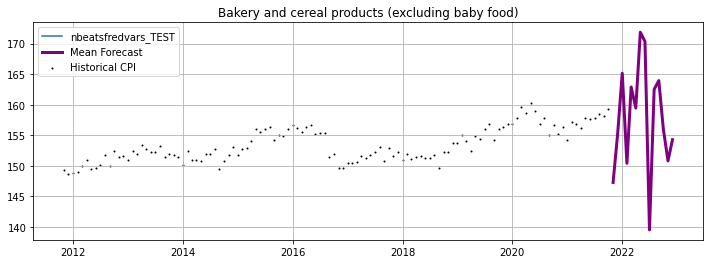

nbeatsfredvars_TEST


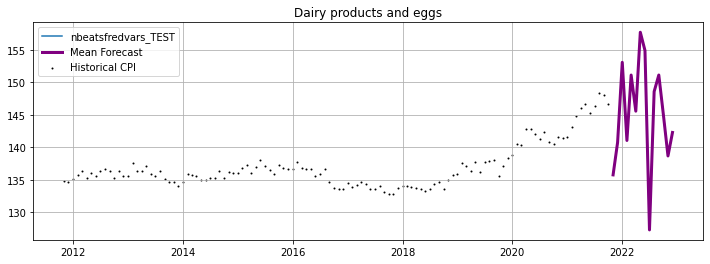

nbeats_TEST
nbeatsfredvars_TEST
prophet_TEST


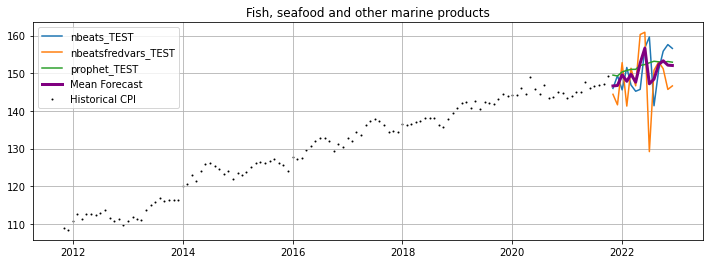

nbeatsfredvars_TEST


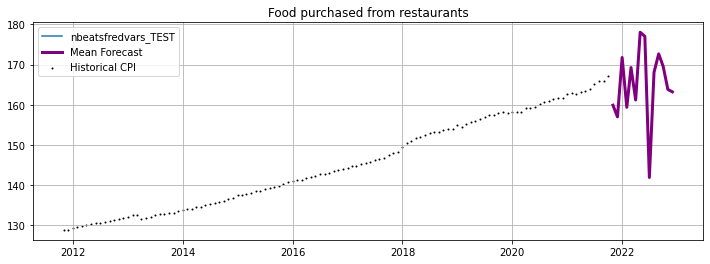

nbeatsfredvars_TEST
prophet_TEST


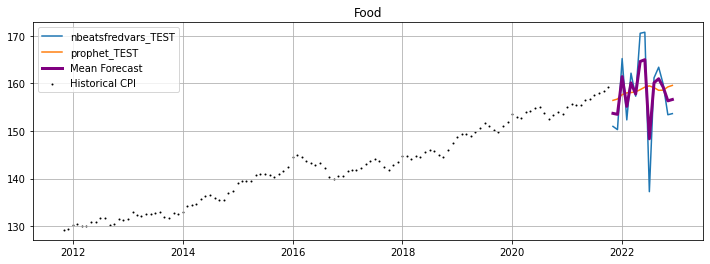

nbeatsfredvars_TEST
prophet_TEST


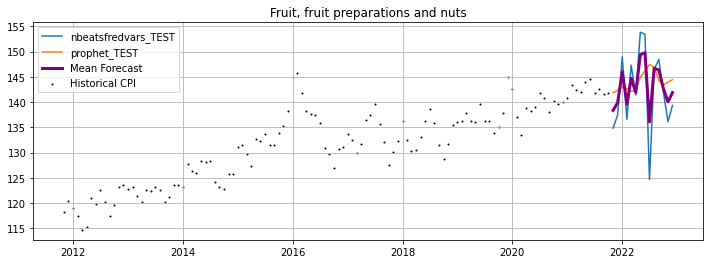

nbeatsfredvars_TEST


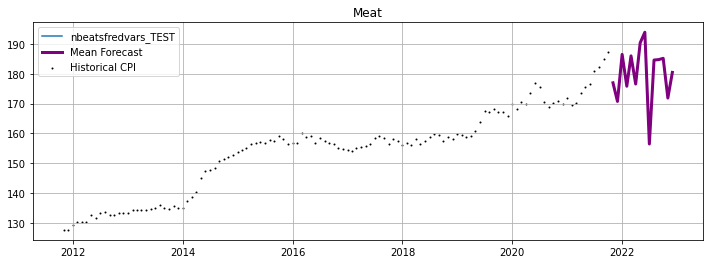

nbeatsfredvars_TEST
prophet_TEST


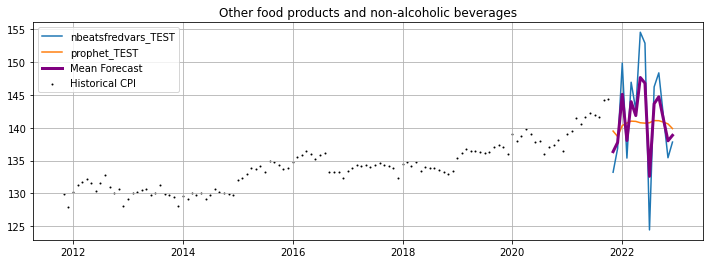

nbeatsfredvars_TEST
prophet_TEST


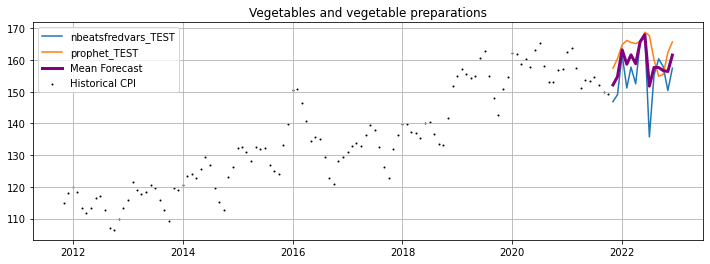

In [13]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))
    final_forecasts_df = get_final_forecast_ensemble(category, results)
    final_forecasts_df = final_forecasts_df.loc[final_forecasts_df.index < "2023-01-01"]

    for index, col in enumerate(final_forecasts_df):
        ax.plot(final_forecasts_df[col], color=f"C{index}", label=col)

    ax.plot(final_forecasts_df.mean(axis=1), color="purple", label="Mean Forecast", lw=3)
    ax.scatter(foodprice_df[category].index[-120:], foodprice_df[category].iloc[-120:], color='black', s=1, label='Historical CPI')

    plt.title(category)
    plt.legend()
    plt.grid()
#     plt.savefig(f"./report_output/ensemble_forecast_raw_{category}.svg", bbox_inches='tight')
    plt.show()
    


nbeatsfredvars_TEST


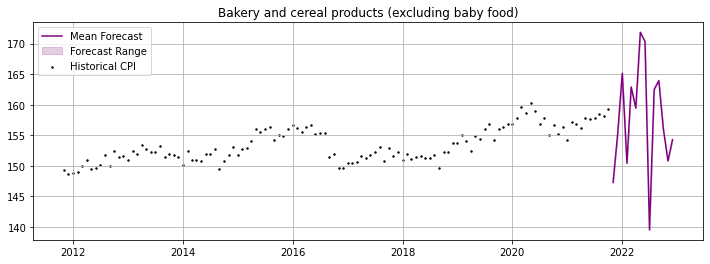

nbeatsfredvars_TEST


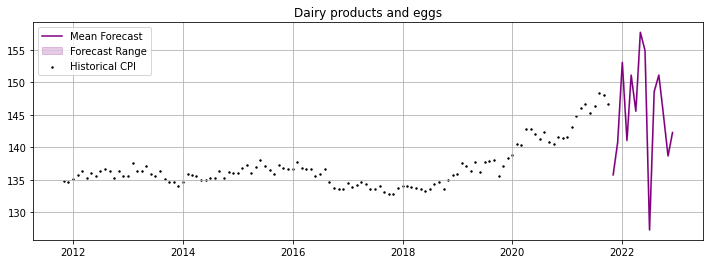

nbeats_TEST
nbeatsfredvars_TEST
prophet_TEST


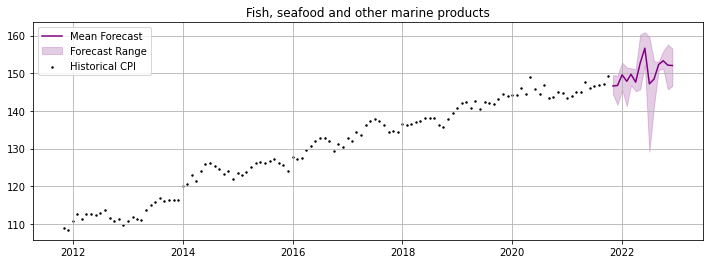

nbeatsfredvars_TEST


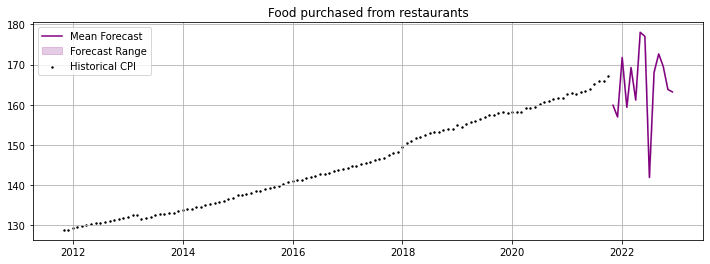

nbeatsfredvars_TEST
prophet_TEST


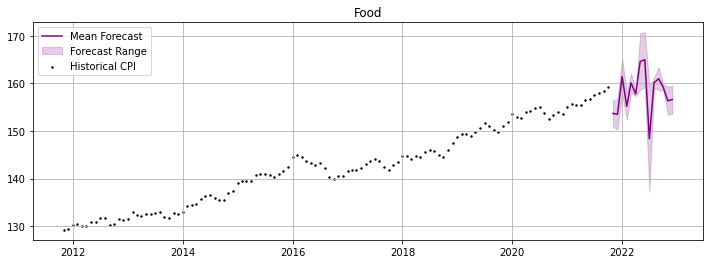

nbeatsfredvars_TEST
prophet_TEST


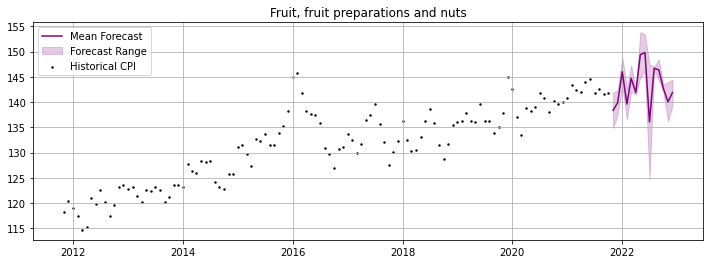

nbeatsfredvars_TEST


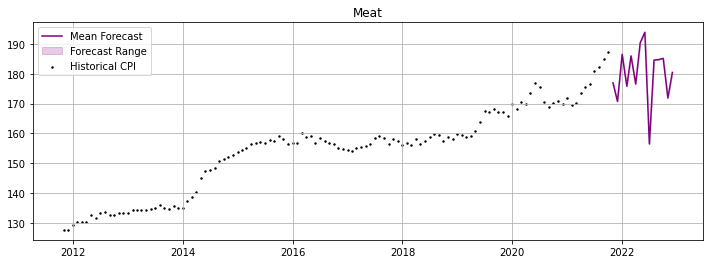

nbeatsfredvars_TEST
prophet_TEST


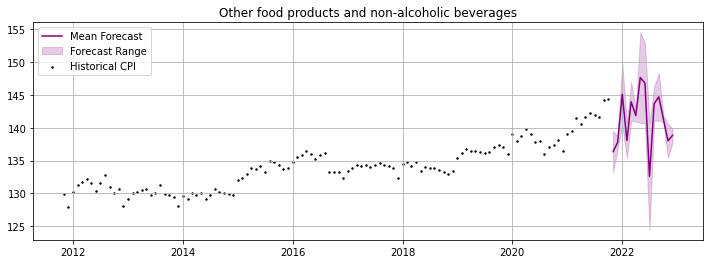

nbeatsfredvars_TEST
prophet_TEST


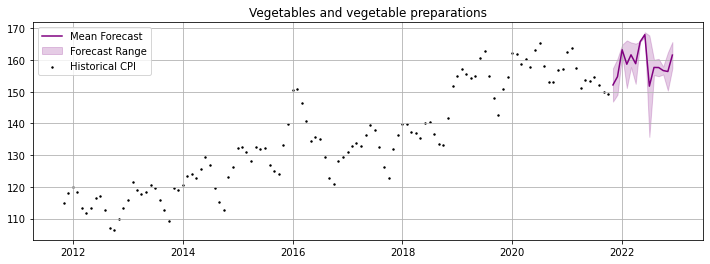

In [14]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))
    final_forecasts_df = get_final_forecast_ensemble(category, results)
    final_forecasts_df = final_forecasts_df.loc[final_forecasts_df.index < "2023-01-01"]

    ax.plot(final_forecasts_df.mean(axis=1), color="purple", label="Mean Forecast")
    ax.fill_between(final_forecasts_df.mean(axis=1).index, final_forecasts_df.min(axis=1), final_forecasts_df.max(axis=1), color="purple", alpha=0.2, label='Forecast Range')
    ax.scatter(foodprice_df[category].index[-120:], foodprice_df[category].iloc[-120:], color='black', s=2, label='Historical CPI')

    plt.title(category)
    plt.legend(loc='upper left')
    plt.grid()
    # plt.savefig(f"./report_output/ensemble_forecast_{category}.svg", bbox_inches='tight')
    plt.show()


## Forecast as Predicted Percent Change

Below we compute the expected change in CPI for 2022, relative to mean CPIs in 2021 so far. 

In [15]:
food_forecast_stats = {}
food_forecast_change_stats = {}

for category in food_categories:

    forecast_stats = {}
    forecast_change_stats = {}

    final_forecasts_df = get_final_forecast_ensemble(category, results)
    final_forecasts_df = final_forecasts_df.loc[final_forecasts_df.index < "2023-01-01"]
    historical_cpi = foodprice_df[category]
    
    fc_min = final_forecasts_df.min(axis=1)
    fc_mean = final_forecasts_df.mean(axis=1)
    fc_max = final_forecasts_df.max(axis=1)

    forecast_stats['min'] = historical_cpi.append(fc_min)
    forecast_stats['mean'] = historical_cpi.append(fc_mean)
    forecast_stats['max'] = historical_cpi.append(fc_max)

    food_forecast_stats[category] = pd.DataFrame(forecast_stats)
    food_forecast_stats[category] = food_forecast_stats[category].loc[food_forecast_stats[category].index < "2023-01-01"]

    fc_stats = food_forecast_stats[category].iloc[-12:]
    historical_data = foodprice_df[category].iloc[-9:]

    print(fc_stats)

    forecast_change_stats['2021_mean'] = historical_data.mean()
    forecast_change_stats['2021_max'] = historical_data.max()
    forecast_change_stats['2022_fc_min'] = fc_stats.min().min() 
    forecast_change_stats['2022_fc_mean'] = fc_stats.mean().mean()
    forecast_change_stats['2022_fc_max'] = fc_stats.max().max()

    food_forecast_change_stats[category] = pd.Series(forecast_change_stats)


nbeatsfredvars_TEST
               min    mean     max
2022-01-01 165.137 165.137 165.137
2022-02-01 150.408 150.408 150.408
2022-03-01 162.895 162.895 162.895
2022-04-01 159.443 159.443 159.443
2022-05-01 171.845 171.845 171.845
2022-06-01 170.333 170.333 170.333
2022-07-01 139.514 139.514 139.514
2022-08-01 162.488 162.488 162.488
2022-09-01 163.937 163.937 163.937
2022-10-01 156.050 156.050 156.050
2022-11-01 150.800 150.800 150.800
2022-12-01 154.279 154.279 154.279
nbeatsfredvars_TEST
               min    mean     max
2022-01-01 153.108 153.108 153.108
2022-02-01 141.049 141.049 141.049
2022-03-01 151.146 151.146 151.146
2022-04-01 145.569 145.569 145.569
2022-05-01 157.749 157.749 157.749
2022-06-01 154.938 154.938 154.938
2022-07-01 127.248 127.248 127.248
2022-08-01 148.595 148.595 148.595
2022-09-01 151.149 151.149 151.149
2022-10-01 145.120 145.120 145.120
2022-11-01 138.659 138.659 138.659
2022-12-01 142.286 142.286 142.286
nbeats_TEST
nbeatsfredvars_TEST
prophet_TEST
     

In [16]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)

results_df = pd.DataFrame(food_forecast_change_stats).T
results_df

,2021_mean,2021_max,2022_fc_min,2022_fc_mean,2022_fc_max
Bakery and cereal products (excluding baby food),157.7,159.3,139.5,158.9,171.8
Dairy products and eggs,146.1,148.3,127.2,146.4,157.7
"Fish, seafood and other marine products",146.4,149.3,129.2,150.4,160.9
Food purchased from restaurants,164.5,167.1,141.9,166.3,178.1
Food,157.0,159.2,137.2,158.8,170.8
"Fruit, fruit preparations and nuts",142.6,144.5,124.7,143.8,153.8
Meat,177.8,187.1,156.5,181.0,193.9
Other food products and non-alcoholic beverages,142.0,144.4,124.4,141.9,154.6
Vegetables and vegetable preparations,154.0,163.8,135.8,159.9,168.8


In [17]:
results_df[['2021_mean', '2022_fc_mean']]

,2021_mean,2022_fc_mean
Bakery and cereal products (excluding baby food),157.7,158.9
Dairy products and eggs,146.1,146.4
"Fish, seafood and other marine products",146.4,150.4
Food purchased from restaurants,164.5,166.3
Food,157.0,158.8
"Fruit, fruit preparations and nuts",142.6,143.8
Meat,177.8,181.0
Other food products and non-alcoholic beverages,142.0,141.9
Vegetables and vegetable preparations,154.0,159.9


In [18]:
## percent change formula from Jim
# P1 = P_0*CPI_1/100 and P2 = P_0*CPI_2/100

p1 = results_df['2021_mean']
p2 = results_df['2022_fc_mean']

(((p2-p1) / p1) * 100).to_frame()


,0
Bakery and cereal products (excluding baby food),0.8
Dairy products and eggs,0.2
"Fish, seafood and other marine products",2.8
Food purchased from restaurants,1.1
Food,1.2
"Fruit, fruit preparations and nuts",0.8
Meat,1.8
Other food products and non-alcoholic beverages,-0.0
Vegetables and vegetable preparations,3.8


In [19]:
## percent change formula from Jim
# P1 = P_0*CPI_1/100 and P2 = P_0*CPI_2/100

p1 = results_df['2021_max']
p2 = results_df['2022_fc_max']

(((p2-p1) / p1) * 100).to_frame()


,0
Bakery and cereal products (excluding baby food),7.9
Dairy products and eggs,6.4
"Fish, seafood and other marine products",7.8
Food purchased from restaurants,6.6
Food,7.3
"Fruit, fruit preparations and nuts",6.4
Meat,3.6
Other food products and non-alcoholic beverages,7.0
Vegetables and vegetable preparations,3.1


In [20]:
## Actual percent change from 2020 to 2021 (Up to September, 2021)

p1 = foodprice_df.loc[foodprice_df.index < "2021-01-01"]
p1 = p1.loc[p1.index >= "2020-01-01"]
p1 = p1.mean(axis=0).rename("2020 Mean CPI")

p2 = foodprice_df.loc[foodprice_df.index < "2022-01-01"]
p2 = p2.loc[p2.index >= "2021-01-01"]
p2 = p2.mean(axis=0).rename("2021 Mean CPI")

result = (((p2-p1) / p1) * 100).rename("Percent Change")
pd.concat((p1, p2, result), axis=1)

,2020 Mean CPI,2021 Mean CPI,Percent Change
Bakery and cereal products (excluding baby food),157.5,157.4,-0.1
Dairy products and eggs,141.3,145.7,3.1
"Fish, seafood and other marine products",145.1,146.1,0.7
Food purchased from restaurants,159.9,164.3,2.7
Food,153.7,156.8,2.0
"Fruit, fruit preparations and nuts",139.1,142.4,2.4
Meat,171.2,177.2,3.5
Other food products and non-alcoholic beverages,138.0,141.7,2.7
Vegetables and vegetable preparations,159.0,154.8,-2.6


In [21]:
pct_change_from_mean_results = {}
pct_change_from_max_results = {}

for col in ['2022_fc_min', '2022_fc_mean', '2022_fc_max']:
    change = results_df[["2021_mean", col]].T.pct_change(1)
    pct_change_from_mean_results[col] = change.T[col]
    change = results_df[["2021_max", col]].T.pct_change(1)
    pct_change_from_max_results[col] = change.T[col]

In [22]:
pd.DataFrame(pct_change_from_mean_results)* 100

,2022_fc_min,2022_fc_mean,2022_fc_max
Bakery and cereal products (excluding baby food),-11.5,0.8,9.0
Dairy products and eggs,-12.9,0.2,7.9
"Fish, seafood and other marine products",-11.7,2.8,9.9
Food purchased from restaurants,-13.7,1.1,8.3
Food,-12.6,1.2,8.8
"Fruit, fruit preparations and nuts",-12.6,0.8,7.9
Meat,-12.0,1.8,9.0
Other food products and non-alcoholic beverages,-12.4,-0.0,8.9
Vegetables and vegetable preparations,-11.8,3.8,9.6


In [23]:
pd.DataFrame(pct_change_from_max_results)

,2022_fc_min,2022_fc_mean,2022_fc_max
Bakery and cereal products (excluding baby food),-0.1,-0.0,0.1
Dairy products and eggs,-0.1,-0.0,0.1
"Fish, seafood and other marine products",-0.1,0.0,0.1
Food purchased from restaurants,-0.2,-0.0,0.1
Food,-0.1,-0.0,0.1
"Fruit, fruit preparations and nuts",-0.1,-0.0,0.1
Meat,-0.2,-0.0,0.0
Other food products and non-alcoholic beverages,-0.1,-0.0,0.1
Vegetables and vegetable preparations,-0.2,-0.0,0.0
